# PART 3: MODEL CONSTRUCTION & EVALUATION

**Objective:** This notebook will construct and evaluate baseline models to help select a decision-maker within the navigation software.

---

In [150]:
# Data Management
import numpy as np
import pandas as pd
import pickle
from prettytable import PrettyTable

# Modeling
import statsmodels as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_absolute_percentage_error, explained_variance_score 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, validation_curve
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import FeatureImportances, LearningCurve
from yellowbrick.regressor import PredictionError, ResidualsPlot

# Utils
import ast
import pprint
import warnings
from datetime import datetime, timedelta, date
# from random import choice, choices, shuffle, randrange
from time import time
%matplotlib inline
sns.set_style('white')
sns.set_color_codes()
plt.style.use('default')
warnings.filterwarnings("ignore")
pp = pprint.PrettyPrinter(indent=0)

---
---

## 3A: Setup

**Objective**: Read in the clinic data & necessary patient records files.

---

In [151]:
# past_patients_df = pd.read_csv('./uc_past_patients.csv', index_col='pt_id')  # for use when generating new datasets with uc_data_fabricator.ipynb 
past_patients_df = pd.read_csv('./fabricated_data/uc_past_patients.csv', index_col='pt_id')  # for ease of use with pre-generated datasets
past_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1000008,Sara Olson,1989-10-28,32,denver,cold/flu/fever,4,2021-05-01,Saturday,08:52:28,09:53:28,1,0.0,4,1
1000005,Joshua Miller,1984-03-15,38,denver,injury/accident,5,2021-05-01,Saturday,09:01:23,10:21:23,2,4.0,4,1
1000003,Zachary Flores,1961-05-23,61,denver,vaccination,3,2021-05-01,Saturday,09:02:10,09:33:10,3,4.5,4,1
1000018,Michael West,2001-12-10,20,denver,vaccination,3,2021-05-01,Saturday,09:13:27,09:34:27,4,4.0,4,2
1000015,Julie Brandt,1994-03-05,28,denver,cough,4,2021-05-01,Saturday,09:16:42,10:13:18,5,3.8,4,2


In [152]:
# new_patients_df = pd.read_csv('./uc_new_patients.csv', index_col='pt_id')  # for use when generating new datasets with uc_data_fabricator.ipynb 
new_patients_df = pd.read_csv('./fabricated_data/uc_new_patients.csv', index_col='pt_id')  # for ease of use with pre-generated datasets
new_patients_df.head()

,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,checkout_time,rolling_ct,rolling_code,assigned_num_techs,needed_num_techs
pt_id,,,,,,,,,,,,,,
1026728,Alexander Romero,1983-11-21,38,denver,cold/flu/fever,4,2022-05-01,Sunday,08:52:10,09:56:10,1,0.0,3,1
1026730,Kayla Wells,1967-05-15,55,denver,vaccination,3,2022-05-01,Sunday,09:01:47,09:27:47,2,4.0,3,1
1026729,Michael Hernandez,1957-06-16,64,denver,cuts/abscess,5,2022-05-01,Sunday,09:09:46,09:59:46,3,3.5,3,1
1026747,Donald Sawyer,1993-05-08,29,denver,UTI,4,2022-05-01,Sunday,09:27:52,10:13:52,3,4.5,3,1
1026738,Andrea Adams,1989-02-22,33,denver,stomach-pain,5,2022-05-01,Sunday,10:06:42,11:30:42,1,0.0,3,1


In [153]:
clinics_df = pd.read_csv('./fabricated_data/uc_clinics.csv', index_col='branch_name')
# clinics_df

---
---

## 3B: Data Processing

**Objective**: Execute minor cleaning implementations due to lost data characteristics from CSV read-in.

---

#### Retain appropriate data types that were lost from csv read-in:

In [154]:
clinics_df['nearby_clinics'] = clinics_df.nearby_clinics.apply(lambda x: ast.literal_eval(x))  
clinics_df

,lat,lon,to_denver,to_edgewater,to_wheatridge,to_rino,to_lakewood,nearby_clinics
branch_name,,,,,,,,
denver,39.739064,-104.989697,0,12,14,7,14,"[(rino, 7.0), (edgewater, 12.0), (wheatridge, ..."
edgewater,39.753954,-105.067788,14,0,5,12,9,"[(wheatridge, 5.0), (lakewood, 9.0), (rino, 12..."
wheatridge,39.766857,-105.081983,14,5,0,10,9,"[(edgewater, 5.0), (lakewood, 9.0), (rino, 10...."
rino,39.767328,-104.981132,6,14,14,0,14,"[(denver, 6.0), (edgewater, 14.0), (wheatridge..."
lakewood,39.704552,-105.079883,12,8,8,12,0,"[(edgewater, 8.0), (wheatridge, 8.0), (denver,..."


The fabricated datasets were stored as CSV files for ease of access of the raw data source. However, as list objects are converted to strings, this was reversed through the `ast` module in the codeblock above.

#### Create appropriate datetime objects for visit date & check-in/out times:

In [155]:
def clean_pt_records(df):
    """Convers datetime info to appropriate formats from csv read-in data."""
    
    # Create unified date/time attribute for sorting purposes
    datetime_str = []
    for i in zip(df.visit_date, df.checkin_time):
        datetime_str.append(i[0] + ' ' + i[1])
    df['datetime'] = datetime_str

    # Sort based on datetime strings
    df = df.sort_values('datetime') #[50:200]

    # Rearrange column order
    df = df[['datetime'] + df.columns.tolist()[:-1]]
    
    # Convert visit date & check-in/out columns to datetime objects (csv converts them into strings)
    df['visit_date'] = df.visit_date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d')).apply(lambda x: x.date())
    df['checkin_time'] = df.checkin_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    df['checkout_time'] = df.checkout_time.apply(lambda x: datetime.strptime(x, '%H:%M:%S')).apply(lambda x: x.time())
    
    return df

In [156]:
past_patients_df = clean_pt_records(past_patients_df)
new_patients_df = clean_pt_records(new_patients_df)

Date & time information was converted into official date-time objects in this section. This data conversion step will prove to be useful during modeling and navigation steps when computations are required based on the specific date and time.

#### Feature engineer necessary attributes:

In [157]:
# Weekend column - 1 for weekend, 0 for weekenday
def feature_engineer(df):
    df['weekend'] = df['visit_day'].copy().apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)
    df['hour'] = df['checkin_time'].copy().apply(lambda x: x.hour)
    df = pd.concat([df, pd.get_dummies(df['visit_location'])], axis=1)
    df['hour'] = df.hour.astype('category')
    # print(df.dtypes)
    return df

The function above extracts hour information based on the check-time, and distinguishes days based on weekday vs. weekend. These would be attributes of interest when constructing a regression model. The reason for requiring hour, rather than the entire check-in time, is that due to the diversity in patient traffic--the goal is to minimize the otherwise large range of possible values for the categorical variable of exact check-in times. Rather, the hour of check-in will ensure the model isn't being overtrained on times specified down to the second, but rather the general hour group. 

In [158]:
new_patients_df = feature_engineer(new_patients_df)
past_patients_df = feature_engineer(past_patients_df)

In [159]:
past_patients_df

,datetime,pt_name,pt_dob,pt_age,visit_location,visit_reason,visit_code,visit_date,visit_day,checkin_time,...,rolling_code,assigned_num_techs,needed_num_techs,weekend,hour,denver,edgewater,lakewood,rino,wheatridge
pt_id,,,,,,,,,,,,,,,,,,,,,
4000001,2021-05-01 08:03:20,Erica Nguyen,1971-11-14,50,rino,weakness/dizziness,5,2021-05-01,Saturday,08:03:20,...,0.0,3,1,1,8,0,0,0,1,0
4000008,2021-05-01 08:05:02,Zachary Brown,1978-11-24,43,rino,cold/flu/fever,4,2021-05-01,Saturday,08:05:02,...,5.0,3,1,1,8,0,0,0,1,0
4000010,2021-05-01 08:07:25,Sheila Miles,2006-12-10,15,rino,covid-test,4,2021-05-01,Saturday,08:07:25,...,4.5,3,1,1,8,0,0,0,1,0
4000002,2021-05-01 08:07:48,Spencer Mendez,1944-01-11,78,rino,weakness/dizziness,5,2021-05-01,Saturday,08:07:48,...,4.3,3,2,1,8,0,0,0,1,0
4000011,2021-05-01 08:12:08,Rachael Larson,2003-01-16,19,rino,covid-test,4,2021-05-01,Saturday,08:12:08,...,4.5,3,2,1,8,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5022911,2022-04-30 19:36:07,Erica Aguilar,1974-07-15,47,lakewood,chest-pain,5,2022-04-30,Saturday,19:36:07,...,4.2,3,2,1,19,0,0,1,0,0
5022923,2022-04-30 19:39:33,Sarah Taylor,1972-03-10,50,lakewood,ear-pain,4,2022-04-30,Saturday,19:39:33,...,4.3,3,3,1,19,0,0,1,0,0
3021410,2022-04-30 19:44:32,Scott Garcia,1948-06-07,73,wheatridge,sore-throat,4,2022-04-30,Saturday,19:44:32,...,0.0,3,1,1,19,0,0,0,0,1


---
---

## 3C: Modeling-Regression

**Objective**: Construct, validate, and evaluate traditional ML models to predict techs-needed at a particular time & location based on past patient records.

---

#### Data Partitioning:

In [160]:
X_train = past_patients_df[['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood', 'weekend', 'hour']].copy()
y_train = past_patients_df['needed_num_techs'].copy()

X_test = new_patients_df[['denver', 'edgewater', 'wheatridge', 'rino', 'lakewood', 'weekend', 'hour']].copy()
y_test = new_patients_df['needed_num_techs'].copy()

The past patient records was used as the training set, while the "new" patient records will serve as the test set. This yields an entire year of data for the training phase, and a new month for the test phase. 

#### Baseline Modeling:

In [161]:
def fit_model(model, X, y, table):
    """Constructs a given model based on input data and evaluates results among relevant metrics."""
    
    model = model.fit(X, y)
    pred = model.predict(X)
    r2 = round(r2_score(y, pred), 2)
    mae = round(mean_absolute_error(y, pred), 2)
    rmse = round(np.sqrt(mean_squared_error(y, pred)), 2)
    medae = round(median_absolute_error(y, pred), 2)  
    mape = round(mean_absolute_percentage_error(y, pred),2) 
    table.add_row([model, r2, mae, rmse, medae, mape])
    return table

def exec_regr(X, y, rs=42):
    """Executes streamlined-process using the input target variable."""
    
    # Define set of baseline models to iterate through
    models = [
        LinearRegression(),
        Lasso(random_state=rs),
        ElasticNet(random_state=rs),
        Ridge(random_state=rs),
        KNeighborsRegressor(),
        DecisionTreeRegressor(random_state=rs),
        RandomForestRegressor(random_state=rs),
    ]

    # Instantiate a tabular structure to store results from each model
    table = PrettyTable()
    table.field_names = ['Model', 'R2', 'MAE', 'RMSE', 'MedAE', 'MAPE']
    
    # Execute model
    for model in models:
        table = fit_model(model, X, y, table)

    return table

print(exec_regr(X_train, y_train))

+----------------------------------------+-------+------+------+-------+------+
|                 Model                  |   R2  | MAE  | RMSE | MedAE | MAPE |
+----------------------------------------+-------+------+------+-------+------+
|           LinearRegression()           |  0.1  | 0.64 | 0.81 |  0.56 | 0.4  |
|         Lasso(random_state=42)         |  0.0  | 0.6  | 0.85 |  0.98 | 0.39 |
|      ElasticNet(random_state=42)       |  0.0  | 0.6  | 0.85 |  0.98 | 0.39 |
|         Ridge(random_state=42)         |  0.1  | 0.64 | 0.81 |  0.56 | 0.4  |
|         KNeighborsRegressor()          | -0.05 | 0.68 | 0.87 |  0.6  | 0.38 |
| DecisionTreeRegressor(random_state=42) |  0.29 | 0.58 | 0.72 |  0.49 | 0.35 |
| RandomForestRegressor(random_state=42) |  0.29 | 0.58 | 0.72 |  0.5  | 0.35 |
+----------------------------------------+-------+------+------+-------+------+


A variety of regressor estimators were chosen to model the data, ranging from linear-regression based algorithms (including `Lasso`/`Ridge`/`ElasticNet`) to K-Nearest Neighbors to tree-based methods. 

The primary area where the linear-based regression techniques (standard `LinearRegression`, `Lasso`, `Ridge`, `ElasticNet`) differ is the penalization for weights assigned to the features. While the standard version has no penalities, Lasso aims to penalize based on sum of absolute values of weights and Ridge penalizes based on sum of squared weight values. 

On the other hand, tree-based regressors rely on a single tree (`DecisionTreeRegressor`) or an ensemble of trees (`RandomForestRegressor`) constructed from a set of binary splits of branches based on the satisfaction of attribute conditions that aim to reduce mean squared error with each split. A random forest algorithm aims to builds many random trees in parallel and is especially known for its predictive power; however, tree-based methods have a knack for overfitting data. 

Exploring these diverse methods, and assessing the models based on relevant metrics can help further narrow down the suitable method that best represents this dataset.

The relevant metrics chosen to evaluate the diverse set of regression models are: R^2, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Median Absolute Error (MedAE), and Mean Absolute Percentage Error (MAPE). Outlined below is a high-level overview on how to interpret these metrics and the context in which they are used, followed by a discussion of the results: 

`R^2`: Higher R^2 value indicates that the model accounts for the variability of the dataset, while a lower value (usually) indicates a worse fit. The disadvantage of this metric is that the value never takes a negative impact with the addition of more features (even if it is a poor predictor). However, since a simplified feature-set was used for this study, this problem is less relevant.

`MAE`: This metric is computed by simply averaging the absolute errors for each record (therefore, a lower value indicates better predictability). This metric is often used in the case of outlier data, which is less prevelant to this study.

`MedAE`: This is computed similar to MAE but uses median instead of mean, to make it even more robust to outliers. 

`MAPE`: In this version, percentages of the errors are used instead, also known for its robustness to outliers. 

`RMSE`: The square-root of the mean squared error (MSE) is taken to compute RMSE. The advantage of MSE and RMSE is that they are both differentiable functions, meaning they can be used in models that employ a loss-function in the algorithm. However, unlike MAE, this metric is not robust to outliers. An advantage of RMSE is that it is measured in the same units as the target variable, making it especially convenient while explaining results to a stakeholder. Therefore, this will be the main metric of interest for this project when evaluating models.

The table above shows the scoring of various baseline regression models, evaluated among relevant metrics. From this, we can assess the tree-based models outperform all others and should be tuned further to see if the scoring can be improved. As the baseline decision-tree performed equivalent to the random-forest regressor, it proves to be an appealing model of choice for further tuning and implementation in the navigation software since the model complexity will be simpler and more explainable to stakeholders. However, there are other advantages with selecting random-forest regressor for further tuning. As this project is being conducted on a fabricated dataset that has a limited feature-set, using a random-forest regressor might prove to be more translateable when working with client-given datasets that might require the robustness of ensemble tree models. Therefore, the random-forest regressor will be further tuned and optimized through a grid-search below.

#### Model Tuning (for best baseline performer):

In [162]:
param_grid = [{
    "n_estimators": [40, 60, 80],
    "max_depth": [8, 10, 12]
}]

gs = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid, cv=3) 
gs.fit(X_train, y_train)
rf = gs.best_estimator_

print(rf)

train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)

print('RMSE of training set predictions: ', np.sqrt(mean_squared_error(y_train, train_pred)))
print('RMSE of test set predictions: ', np.sqrt(mean_squared_error(y_test, test_pred)))

RandomForestRegressor(max_depth=10, n_estimators=60, random_state=42)
RMSE of training set predictions:  0.7196900555732495
RMSE of test set predictions:  0.7191170831392659


Conducting a grid search to explore the most effective combination of number of trees and tree depth showed that the ideal parameters output similar results to the baseline model. The RMSE scores generalize extremely well to the test set as well, which is to be expected in this case where the dataset was made from the same source of fabrication steps. Therefore, to truly examine the applicability of this model to new datasets, we require client-based datasets to determine how diverse day-to-day traffic is to be able to test out the model. For now, this model will be explored further to study the results.

#### Analyze best regressor:

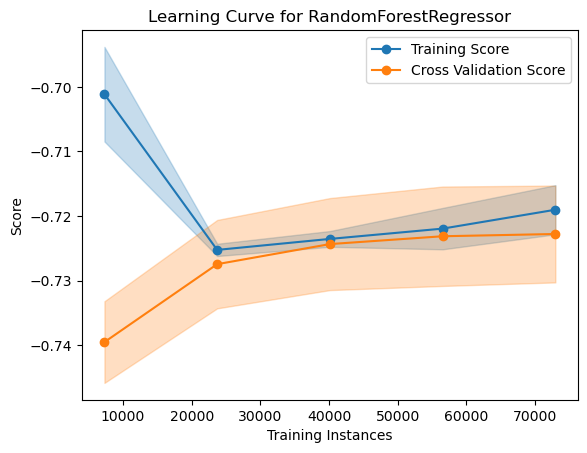

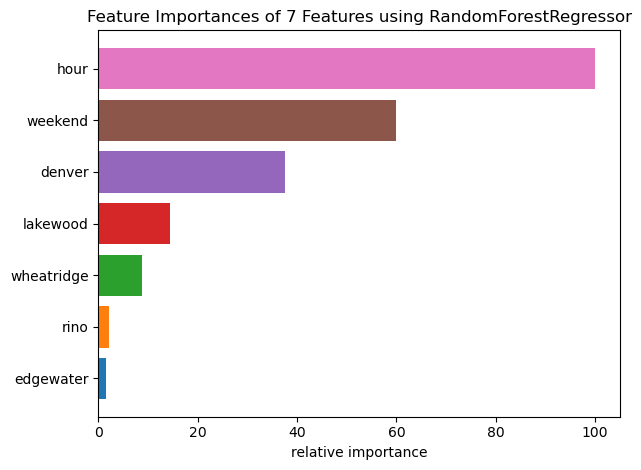

In [163]:
# residuals_plot = ResidualsPlot(rf)
# residuals_plot.fit(X_train, y_train).score(X_test, y_test)
# residuals_plot.show()

rf.fit(X_train, y_train)

lc = LearningCurve(rf, scoring='neg_root_mean_squared_error', cv=3)
lc.fit(X_train, y_train).score(X_test, y_test)
lc.show()

fi = FeatureImportances(rf)
fi.fit(X_train, y_train).score(X_test, y_test)
fi.show()
plt.show()

Take-Aways:

Further model tuning to optimize the best baseline performer (tree-based random-forest) on negligibly improves the RMSE score for our target variable. However, the model does seem to generalize well to the test-set which is to be expected due to the fact that this project involved generating the source datasets. 
RMSE of around 1 indicates that the model is, on average, off by 1 tech in predicting how many a clinic needs at any given moment in time, for any location. Since majority of the instances involve more than 1 available tech at a nearby clinic, this model will only need to be executed occasionally throughout the day for the TecNav navigator app. 
Based on the learning curve, there is no immediate danger of model overfitting as the increased number of train instances is contributing to a better validation RMSE score.

Based on the feature importances, the hour of the day seems to be the most important feature to determine a clinic's need for the number of technicians, more than the actual location attribute. The type of day also seems to play a huge role. In terms of the location, knowing whether a patient record belongs to the Denver clinic seems to be the most important location to assess while predicting the target---since the EDA showed that this clinic sees the largest traffic, this might indicate the total patient count to be a significant factor in forecasting the number of needed technicians.

Although this was a fairly limited feature-set that restricts our ability to be able to conduct a feature-selection investigation, the advantage of constructing a model in this fashion is the translatable application to real-world data from potential clients. As we cannot predict what attributes we can get from a client's dataset and its predictive-power, a simpler model complexity with features that will likely be present was the avenue we chose here. Nevertheless, these attributes may not prove useful with new datasets and therefore, it would be prudent to explore modeling techniques that don't rely on specific attributes other than the target variable itself. To that extent, an alternative forecasting approach will be conducted below.

---
---

## 3C: Modeling-ARIMA

**Objective**: Construct, validate, and evaluate time series analyses to predict rolling count based on past patient records.

---

### Feature engineering to prepare data for Time-Series:

In [164]:
filtered_df = past_patients_df[['visit_date', 'visit_location', 'checkin_time', 'needed_num_techs']].copy()
filtered_df['visit_date'] = filtered_df.visit_date.apply(lambda x: str(x))

def floor_dt(current):
    today = date.today()
    current = datetime.combine(today, current)
    rounded_time = current - (current - datetime.min) % timedelta(minutes=15)
    return str(rounded_time.time())[:-3]
filtered_df['interval_time'] = filtered_df.checkin_time.apply(lambda x: floor_dt(x))

filtered_df = filtered_df.groupby(['visit_date', 'visit_location', 'interval_time']).median().round().reset_index(drop=False).sort_values(by=['visit_location', 'visit_date', 'interval_time'])
filtered_df = filtered_df.sort_values(by=['visit_date', 'interval_time', 'visit_location'])
filtered_df

,visit_date,visit_location,interval_time,needed_num_techs
96,2021-05-01,rino,08:00,1.0
30,2021-05-01,edgewater,08:15,1.0
97,2021-05-01,rino,08:15,2.0
127,2021-05-01,wheatridge,08:15,1.0
64,2021-05-01,lakewood,08:30,1.0
...,...,...,...,...
59689,2022-04-30,denver,19:30,1.0
59754,2022-04-30,lakewood,19:30,2.0
59818,2022-04-30,wheatridge,19:30,1.0
59755,2022-04-30,lakewood,19:45,2.0


In the code block above, each check in time was rounded down to the most recent 15-minute mark, for standardization across the days to be able to construct a model (as was done before the machine-learning model explorations in the previous section). In order to use time-series, however, another step is required. Not only do the times have to be standardized, there needs to be an even interval between each time period every day. For example, if a check-in time occured at 10:13 and the next occured at 10:31, a 15-min interval rounding would convert them into 10:00 and 10:30, but there will be a missing record at 10:15. Therefore, these must be included with a forward-fill to ensure there is consistency in the intervals before employing any time series models. These data engineering steps will be conducted below.

In [165]:
filtered_df = filtered_df[filtered_df.visit_date.str.contains('2021-05')]

all_intervals = filtered_df.interval_time.unique()
rows = []
for d in filtered_df.visit_date.unique():
    for i in all_intervals:
        rows.append([d, 'denver', i])
        rows.append([d, 'wheatridge', i])
        rows.append([d, 'edgewater', i])
        rows.append([d, 'rino', i])
        rows.append([d, 'lakewood', i])
ts_df = pd.DataFrame(rows, columns=['visit_date', 'visit_location', 'time'])

ts_df = ts_df.sort_values(by=['visit_date', 'time', 'visit_location'])
ts_df

,visit_date,visit_location,time
0,2021-05-01,denver,08:00
2,2021-05-01,edgewater,08:00
4,2021-05-01,lakewood,08:00
3,2021-05-01,rino,08:00
1,2021-05-01,wheatridge,08:00
...,...,...,...
7435,2021-05-31,denver,19:45
7437,2021-05-31,edgewater,19:45
7439,2021-05-31,lakewood,19:45
7438,2021-05-31,rino,19:45


A new dataframe was generated above will all the possible time intervals for every day in the filtered timeframe of interest. 

In [166]:
ts_df['needed_num_techs'] = ts_df[['visit_location', 'visit_date', 'time']].apply(lambda x: filtered_df[
    (filtered_df.visit_location == x[0]) & (filtered_df.visit_date == x[1]) & (filtered_df.interval_time == x[2])
]['needed_num_techs'].values, axis=1)
ts_df['needed_num_techs'] = ts_df['needed_num_techs'].apply(lambda x: x[0] if len(x)>0 else np.nan)
ts_df = ts_df.fillna(method='ffill')
ts_df = ts_df.fillna(1)
ts_df

,visit_date,visit_location,time,needed_num_techs
0,2021-05-01,denver,08:00,1.0
2,2021-05-01,edgewater,08:00,1.0
4,2021-05-01,lakewood,08:00,1.0
3,2021-05-01,rino,08:00,1.0
1,2021-05-01,wheatridge,08:00,1.0
...,...,...,...,...
7435,2021-05-31,denver,19:45,1.0
7437,2021-05-31,edgewater,19:45,1.0
7439,2021-05-31,lakewood,19:45,1.0
7438,2021-05-31,rino,19:45,1.0


Each missing time-interval slot was filled with its most recent value to complete the feature engineering process and the first slot of each day (if missing) was filled with 1, as every clinic will at least need 1 technician to start the day, no matter the number of patients.

In [167]:
ts_df['dt'] = ts_df[['visit_date', 'time']].apply(lambda x: x[0] + ' ' + x[1], axis=1)

In [168]:
denver_df = ts_df[ts_df.visit_location == 'denver']
wheatridge_df = ts_df[ts_df.visit_location == 'wheatridge']
edgewater_df = ts_df[ts_df.visit_location == 'edgewater']
rino_df = ts_df[ts_df.visit_location == 'rino']
lakewood_df = ts_df[ts_df.visit_location == 'lakewood']

The engineered dataset was broken by location to explore ARIMA methods for each clinic separately. Unlike the traditional regression techniques, this breakdown is necessary for ARIMA. That is because time-series doesn't rely on external attributes (such as location that was used as part of the feature-set of the random forest algorithm). However, since location had a fairly large role on determining patient traffic (as can be expected due to the fabrication strategy), executing separate ARIMA models for each location is the most feasible approach to maximize chances of strong forecasts. 

### ARIMA:

To first explore the potency of ARIMA models for this data, a week of Denver clinic's data will be used as a preliminary attempt to help inform the process for large-scale execution.

In [169]:
denver_df

,visit_date,visit_location,time,needed_num_techs,dt
0,2021-05-01,denver,08:00,1.0,2021-05-01 08:00
5,2021-05-01,denver,08:15,1.0,2021-05-01 08:15
10,2021-05-01,denver,08:30,1.0,2021-05-01 08:30
15,2021-05-01,denver,08:45,1.0,2021-05-01 08:45
20,2021-05-01,denver,09:00,1.0,2021-05-01 09:00
...,...,...,...,...,...
7415,2021-05-31,denver,18:45,1.0,2021-05-31 18:45
7420,2021-05-31,denver,19:00,1.0,2021-05-31 19:00
7425,2021-05-31,denver,19:15,1.0,2021-05-31 19:15
7430,2021-05-31,denver,19:30,2.0,2021-05-31 19:30


In [170]:
denver_df = denver_df[denver_df.visit_date.isin(['2021-05-03', '2021-05-04',
       '2021-05-05', '2021-05-06', '2021-05-07', '2021-05-08',
       '2021-05-09'])]

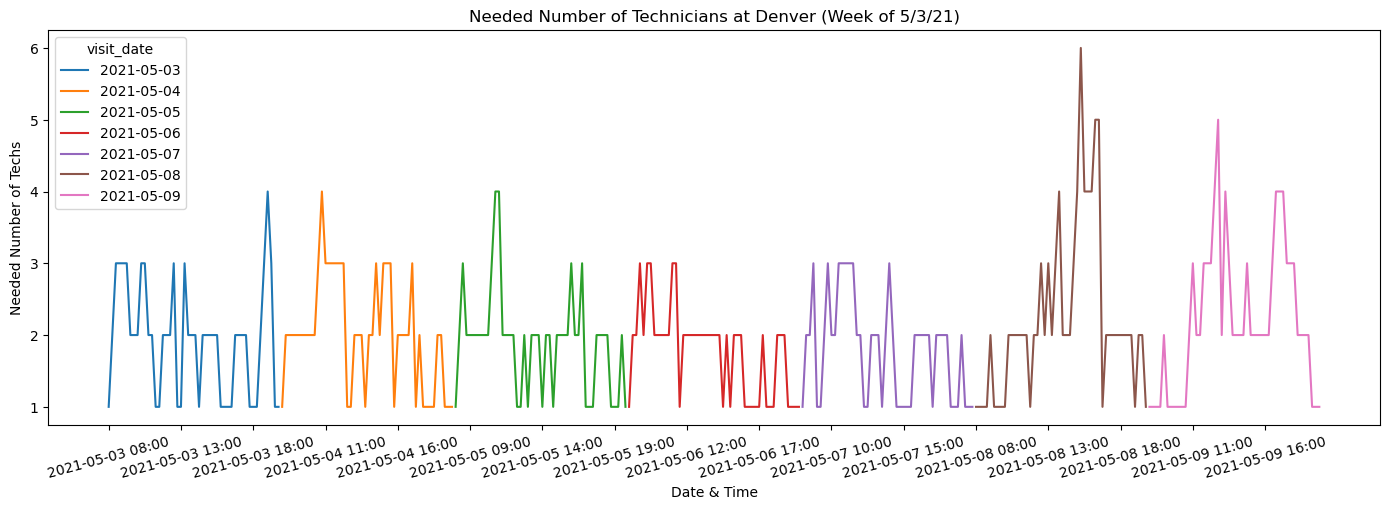

In [171]:
fig, ax = plt.subplots(1,1,figsize=(14,5))
sns.lineplot(x=denver_df['dt'], y=denver_df['needed_num_techs'], hue=denver_df['visit_date'], legend=True)
plt.xticks(denver_df.dt.tolist()[0::20],  rotation=15)
plt.tight_layout()
plt.xlabel('Date & Time')
plt.ylabel('Needed Number of Techs')
plt.title('Needed Number of Technicians at Denver (Week of 5/3/21)')
plt.show()

The visual above breaks down the needed number of technicians at any given point over an entire week at the Denver clinic. Multiple colors were used to separate out each distinct day. As expected from the fabrication stage, the first 5 weekdays show a more similar pattern, compared to the last two weekend days. 

#### Test for stationarity:

A pre-requisite for executing ARIMA is conducting an Augmented Dickey-Fuller test  (ADF) to determine if the data are stationary. In other words, this test ensures the mean stays constant throughout the time series. If this test fails, some differencing steps must be implemented to transform the non-stationary data. 

In [172]:
denver_df = denver_df.set_index('dt')[['needed_num_techs']]

Setting the time attribute as the dataframe index will provide extra ease-of-use during the modeling.

In [173]:
adf_results = adfuller(denver_df)
print('ADF Test Statistic: ', adf_results[0])
print('p-value: ', adf_results[1])
print('# of Lags Used: ', adf_results[2])

ADF Test Statistic:  -7.647223340054075
p-value:  1.829016403831606e-11
# of Lags Used:  1


The Null-Hypothesis of ADF would state that the data is non-stationary. The p-value below the level of significance (0.05) indicates strong evidence against the null hypothesis (Ho) enabling us to reject it and retain the alternate that the data has no unit root and is stationary. Therefore, ARMA/ARIMA models are feasible with this data. Furthermore, the ADF results indiciate no further need to implement any differencing to transform the data into stationary data.

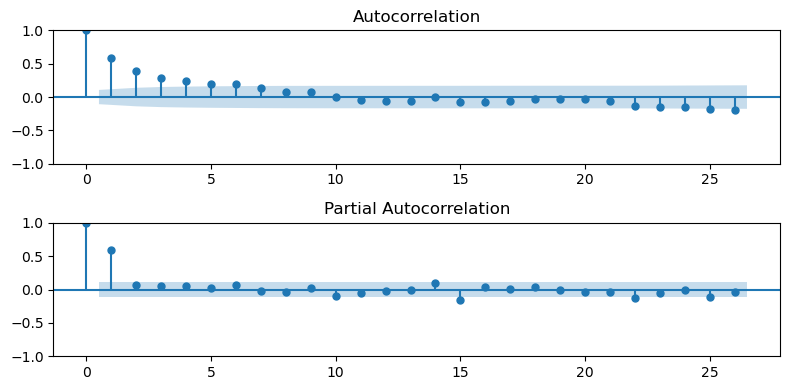

In [174]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4))

plot_acf(denver_df.needed_num_techs, ax=ax[0])
plot_pacf(denver_df.needed_num_techs, ax=ax[1])

plt.tight_layout()
plt.show()

One method to avoid using all the data points and overfitting the ARIMA model is to figure our which lag tends to be the best predictor. To help decide which of these pre-processed intervals should be used for ARIMA forecasting, autocorrelation (ACF) and partial autocorrelation (PCAF) of intervals were plotted. The objective of these plots is to visually determine which lags are more correlated (higher positive or negative spike outside the shaded area indicates significant correlation) for tuning the p & q parameters in the "order" of the ARIMA model. Essentially, autocorrelation serves to show the relation of the target variable with itself at previous time intervals. ACF and PCAF charts help determine the interval parameter for the moving average and autoregressive components, respectively. However, research (as well as examples from Statsmodels package documentation) suggests that these are best used as starting points to begin an ARIMA investigation and then scale down the parameters as needed. Based on the points from above, 6 & 1 seems to be a starting point for p & q that can be attempted below. Since the ADF showed no need for additional differencing steps, the Integration order would be 0.

In [175]:
# Fit model
model = ARIMA(denver_df.needed_num_techs, order=(6, 0, 1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:       needed_num_techs   No. Observations:                  336
Model:                 ARIMA(6, 0, 1)   Log Likelihood                -354.537
Date:                Sat, 28 May 2022   AIC                            727.074
Time:                        12:53:26   BIC                            761.428
Sample:                             0   HQIC                           740.768
                                - 336                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9706      0.135     14.596      0.000       1.706       2.235
ar.L1          0.4107      1.016      0.404      0.686      -1.581       2.403
ar.L2          0.1057      0.550      0.192      0.8

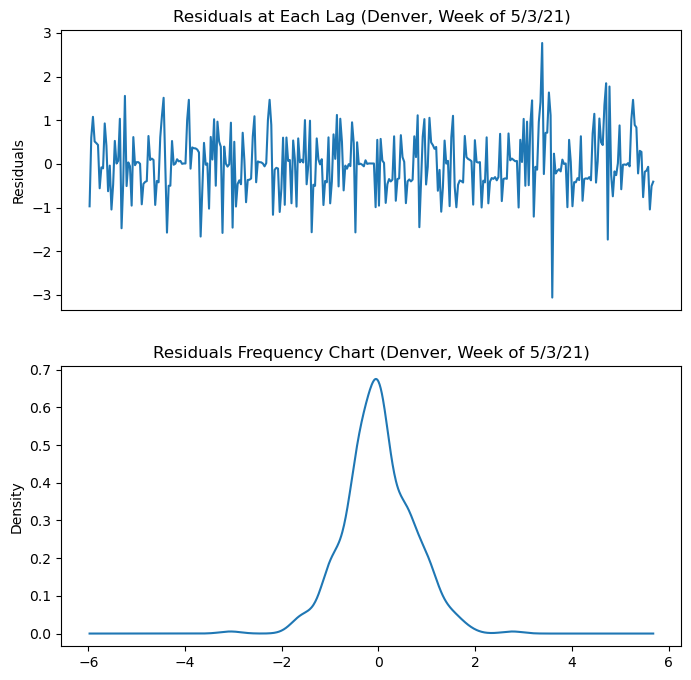

In [176]:
residuals = pd.DataFrame(model_fit.resid)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8))
ax1.plot(residuals)
ax1.tick_params(labelbottom=False, bottom=False)
ax1.set_title('Residuals at Each Lag (Denver, Week of 5/3/21)')    
ax1.set_ylabel('Residuals')    

residuals.plot(kind='kde', ax=ax2, legend=False) # density plot of residuals
ax2.set_title('Residuals Frequency Chart (Denver, Week of 5/3/21)') 
plt.show()

Based on the initial ARIMA execution, the residuals were plotted above. The first plot on the top shows the direct residual value at each prediction point. From this, we see a mostly constant trend, with residuals ranging from -1 to 1. This can be visualized through a KDE plot below it. From this, we can assess the residuals to resemble a normal distribution, with a mean centered around 0. In this case, we can conclude there is no bias in the predictions. 

Test RMSE:  0.844


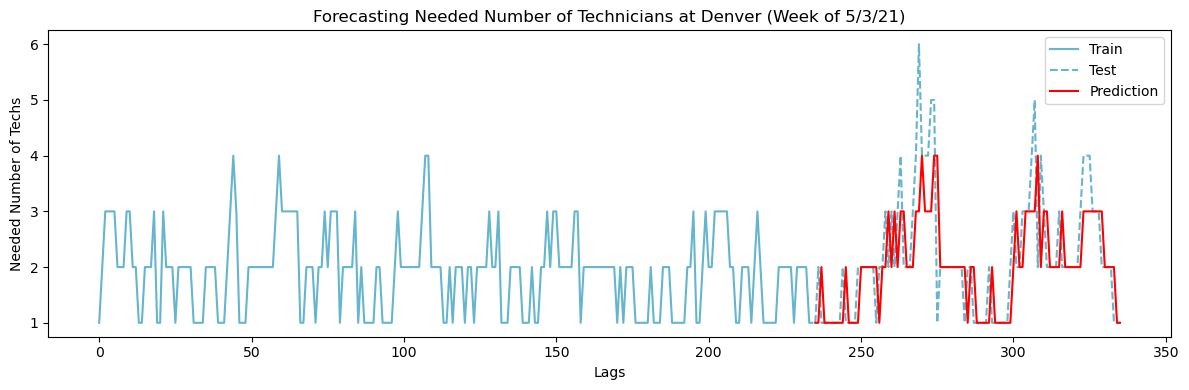

In [177]:
# split into train and test sets
X = denver_df.needed_num_techs.values

size = int(len(X) * 0.7)  # 235
train, test = X[0:size], X[size:len(X)]
history = [i for i in X]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    # print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, [round(i) for i in predictions]))
print('Test RMSE: ', round(rmse, 3))


# plot forecasts against actual outcomes
fig, ax = plt.subplots(1,1,figsize=(12, 4))
plt.plot(X[:235], 'c-')
plt.plot([i for i in range(235, len(X))], X[235:], 'c--')
plt.plot([i for i in range(235, len(X))], [round(i) for i in predictions], color='red')
plt.xlabel('Lags')
plt.ylabel('Needed Number of Techs')
plt.title('Forecasting Needed Number of Technicians at Denver (Week of 5/3/21)')
plt.tight_layout()
plt.legend(['Train', 'Test', 'Prediction'])
plt.show()

After fulfilling the pre-requisites and finding the order to use for the ARIMA model, the final step is the execution itself. As this preliminary exploration is being conducted on a week of Denver clinic's data, 5 days are being used as the training portion, while the remaining 2 days are being used as the test component above. The dotted line represents the actual test values of the needed number of technicians at that given point, whereas the red line is the ARIMA model's forecast. 

There are several important notes to make here. The ARIMA model in the code block above was executed slightly differently--one major difference is the walk-forward validation. As original predictions were poor, this methodology can improve time-series modeling by incorportating the actual value of a predicted point, into the training of the next prediction. However, the down-side to this is the increased time complexity. As our autocorrelation explorations suggested an order of (6,0,1), this would add on to the complexity of the model. However, scaling down this order to (1,0,1) did not significiantly affect the RMSE score (0.827 vs. 0.844) and therefore, this order proves to be the better choice to implement despite the insights from the pre-requisite work. Doing so significantly improves the runtime of the above codeblock, without sacrificing the predictive power. However, there is another advantage to this as well. `Statsmodels` package has a known bug when executing ARIMA models that are especially prevelant with models that require higher computational power. This led to smooth execution on some runs, while erroring out during other runs. Reducing the complexity of the model, however, is a way to avoid this issue as well. (*https://github.com/statsmodels/statsmodels/issues/5459*)

However, the initial RMSE score of above 0.8 does not bode well to ARIMA's forecasting ability over the random forest regressor. Its important to keep in mind, however, that this was done on a micro-level of a single week, of a single location, which is bound to have variation. Therefore, an entire month will be studied below to gauge the potency of ARIMA for this dataset.

#### Conduct time-series (ARIMA) study on for an entire month for each location to examine mean RMSE:

In [178]:
t1 = time()
def exec_arima(loc):
    """Conducts ARIMA time-series analysis for input location and outputs RMSE averaged out for all dates."""
    
    # Keep track of daily RMSE values
    rmses = []
    
    # Iterate through each day of past year dataset
    for dat in ts_df.visit_date.unique().astype('str'):
        
        # Filter dataset for specified location and aggragate interval times
        df = ts_df[(ts_df.visit_date == dat) & (ts_df.visit_location == loc)].copy()
        df = df[['time', 'needed_num_techs']]
        df = df.groupby('time').median()
        
        # Fit ARIMA model for the day and track predictions
        X = df.values
        history = [i for i in X]
        preds = []
        for t in range(len(X)):
            ar = ARIMA(history, order=(1,0,1))
            ar_fit = ar.fit()
            pred = ar_fit.forecast()
            preds.append(pred[0])
            history.append(X[t])
        rmse = np.sqrt(mean_squared_error(X, preds))
        rmses.append(rmse)    
    
    return np.mean(rmses)

print("Mean RMSE for Denver via ARIMA: ", exec_arima('denver'))
print("Mean RMSE for Edgewater via ARIMA: ", exec_arima('edgewater'))
print("Mean RMSE for Wheatridge via ARIMA: ", exec_arima('wheatridge'))
print("Mean RMSE for Rino via ARIMA: ", exec_arima('rino'))
print("Mean RMSE for Lakewood via ARIMA: ", exec_arima('lakewood'))
time()-t1

Mean RMSE for Denver via ARIMA:  0.6915733055407419
Mean RMSE for Edgewater via ARIMA:  0.6473534248607002
Mean RMSE for Wheatridge via ARIMA:  0.6476686042808621
Mean RMSE for Rino via ARIMA:  0.6366051589981128
Mean RMSE for Lakewood via ARIMA:  0.6406352863943399


211.19240975379944

A month (May 2021) of forecasts were retrieved and evaluated for each location above. Using weekly forecasts eliminates the need for adding any seasonality componenent to the base ARIMA model which avoids any unnecessary model complexity. The above study shows only slight improvements in the RMSE scores compared to the random forest regressor, meaning that the ARIMA model is performing on par (for the month of May 2021). Due to the extra time and model complexity of implementing this time series within the TecNav algorithm, the optimized random forest is the better choice to move forward with at this point. 

---
---

## 3E: Navigation Pre-Requisites

**Objective**: Save dataframe and model objects to be used for navigation, to prevent the need for repeating pre-processing steps in next notebook.

---

In [179]:
# Reduce initial scheduled tech assignments by specified amount
past_patients_df['new_num_techs'] = past_patients_df.assigned_num_techs.apply(lambda x: x-1)
new_patients_df['new_num_techs'] = new_patients_df.assigned_num_techs.apply(lambda x: x-1)

In [180]:
past_patients_df.to_pickle('./pickled_objects/past_patients_df.pkl')

new_patients_df.to_pickle('./pickled_objects/new_patients_df.pkl')

pickle.dump(rf, open('./pickled_objects/rf_model.pkl', 'wb'))